In [2]:
import cv2
import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.segmentation import chan_vese, slic, mark_boundaries, active_contour, morphological_chan_vese, morphological_geodesic_active_contour, inverse_gaussian_gradient, checkerboard_level_set, disk_level_set
from skimage.filters import gaussian

from covid.utils import files_paths_labels

In [3]:
PATH_TRAIN_CONTOURS = 'Data/CT-COV-Contour/Train'
PATH_VAL_CONTOURS = 'Data/CT-COV-Contour/Val'

In [4]:
contours_paths_train, contours_labels_train = files_paths_labels(PATH_TRAIN_CONTOURS, 'Train')
contours_paths_val, contours_labels_val = files_paths_labels(PATH_VAL_CONTOURS, 'Val')

Train 4404 4404
Val 1341 1341


## Active contour

In [5]:
def snake_contour(path, num_points=500, radius=250, alpha=0.1, beta=10, gamma=0.001, max_iterations=2500, w_line=1, w_edge=1, center=False, title=None, show_steps=False, crop=True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    if not center:
        non_zero_h = np.argwhere(img[:,int(img.shape[0]//2)])
        center_h = (non_zero_h[0] + non_zero_h[-1]) // 2
        non_zero_w = np.argwhere(img[int(img.shape[1]//2),:])
        center_w = (non_zero_w[0] + non_zero_w[-1]) // 2

    else:
        center_h = img.shape[0]//2
        center_w = img.shape[1]//2
    
#     img = img_as_float(img)
    
    s = np.linspace(0, 2*np.pi, num_points)
    r = center_h + radius*np.sin(s)
    c = center_w + radius*np.cos(s)
    init = np.array([r, c]).T

    snake = active_contour(gaussian(img, 3), init, alpha=alpha, beta=beta, gamma=gamma, coordinates='rc', max_iterations=max_iterations, w_line=w_line, w_edge=w_edge)
    
    snake = np.asarray(snake, dtype=np.int32)
    snake_contour = np.dstack((snake[:,1], snake[:,0]))
    
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    mask = cv2.fillPoly(mask, [snake_contour], (1.0, 1.0, 1.0))
    img_masked = cv2.bitwise_and(img, img, mask=mask)
    output = img_masked
    num_subplots = 2
    
    if crop:
        x, y, w, h = cv2.boundingRect(snake_contour)
        x = np.max([x,0])
        y = np.max([y,0])
        img_lungs_bbox = cv2.rectangle(cv2.cvtColor(img_masked.copy(), cv2.COLOR_GRAY2RGB), (x,y), (x+w,y+h), (0,255,0), 2)
    
        img_cropped = img_masked.copy()
        img_cropped = img_cropped[y:y+h, x:x+w]
        output = img_cropped
        num_subplots = 4
    
    
    if show_steps:
        fig, ax = plt.subplots(1, num_subplots, figsize=(num_subplots*6, 10))
        ax[0].imshow(img, cmap=plt.cm.gray)
        ax[0].plot(init[:, 1], init[:, 0], '--r', lw=3)
        ax[0].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
        ax[0].axis([0, img.shape[1], img.shape[0], 0])
        ax[0].set_title(title)
        ax[0].set_axis_off()
        
        ax[1].imshow(img_masked, cmap='gray')
        ax[1].set_axis_off()
        
        if crop:
            ax[2].imshow(img_lungs_bbox)
            ax[2].set_axis_off()

            ax[3].imshow(img_cropped, cmap='gray')
            ax[3].set_axis_off()
        

    return output

Images with removed background are used to segment the lungs.

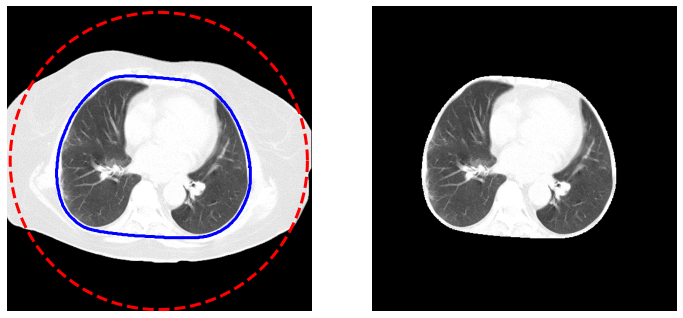

In [6]:
snake_contour(contours_paths_train[0], show_steps=True, crop=False);

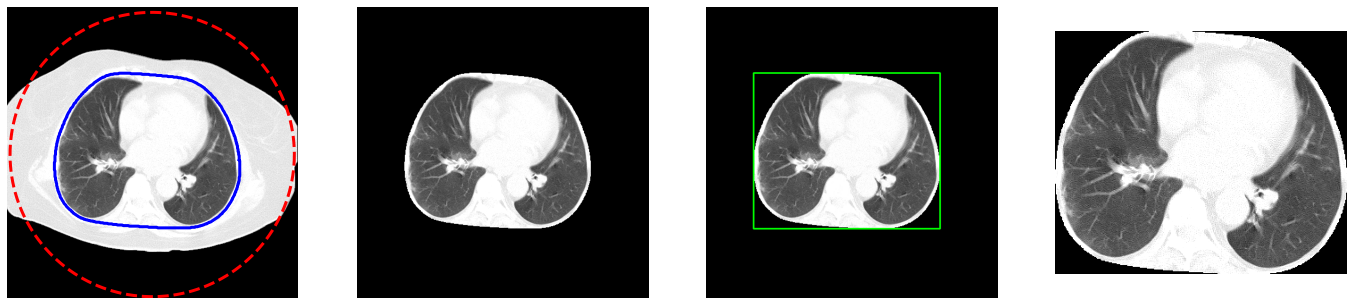

In [7]:
snake_contour(contours_paths_train[0], show_steps=True);

### Problems and solutions

Patient not in the center of the image while the initial circle is in the center:

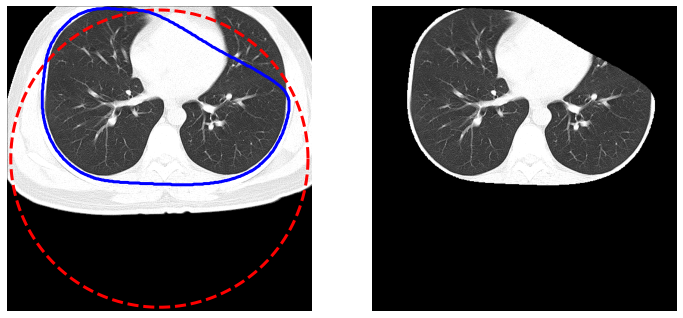

In [8]:
snake_contour(contours_paths_val[1090], crop=False, show_steps=True, center=True);

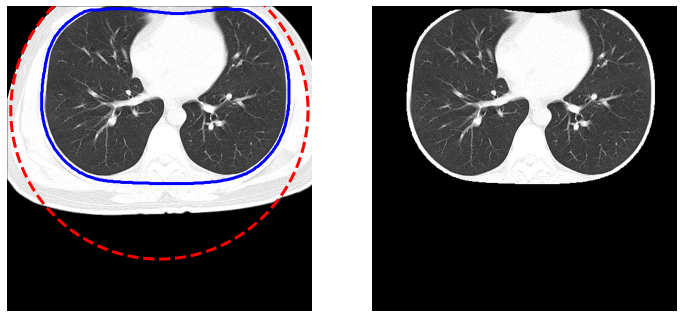

In [9]:
snake_contour(contours_paths_val[1090], crop=False, show_steps=True);

Arms of the patient confuse the active contour:

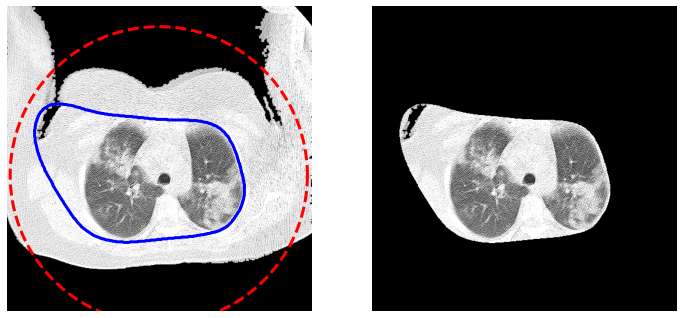

In [10]:
snake_contour(contours_paths_val[498], crop=False, show_steps=True);

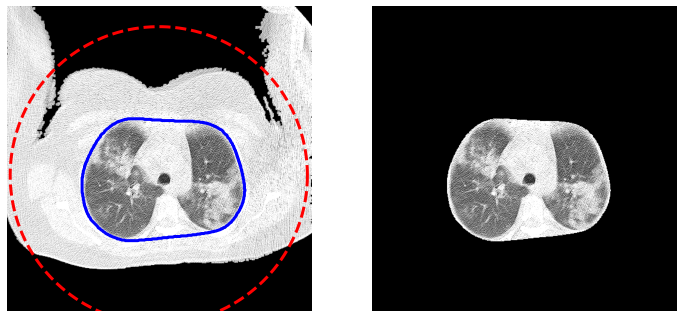

In [11]:
snake_contour(contours_paths_val[498], crop=False, show_steps=True, alpha=0.3);

Active contour too short to include both lungs:

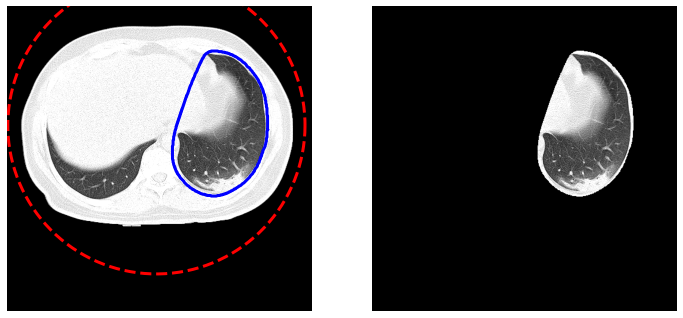

In [12]:
snake_contour(contours_paths_val[82], crop=False, show_steps=True, num_points=400);

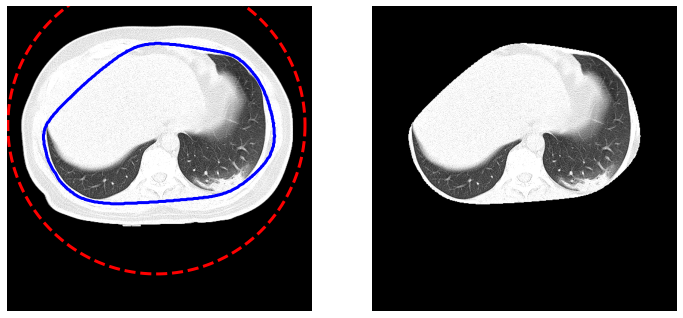

In [13]:
snake_contour(contours_paths_val[82], crop=False, show_steps=True);

### Save to folder

In [ ]:
def save_to_folder(img_paths, img_labels, path_to_folder, if_resize=True, size=(512,512), crop=False):
    
    for i, path in enumerate(img_paths):
        img_ = cv2.imread(path)
        
        if if_resize:    
            if img_.shape[0] != size[0] or img_.shape[1] != size[1]:
                img_ = cv2.resize(img_, size)
        
        img_ = snake_contour(path, crop=crop)

        if img_labels[i] == 'COV':
            status = cv2.imwrite(path_to_folder + '/COV/' + str(i) + '.png', img_)

        elif img_labels[i] == 'Normal':
            status = cv2.imwrite(path_to_folder + '/Normal/' + str(i) + '.png', img_)

        else:
            status = cv2.imwrite(path_to_folder + '/OtherPneumonia/' + str(i) + '.png', img_)

        if not status:
            print('fail', i)

In [ ]:
save_to_folder(contours_paths_train, contours_labels_train, 'Data/CT-COV-Lungs/Train', if_resize=False)

In [ ]:
save_to_folder(contours_paths_val, contours_labels_val, 'Data/CT-COV-Lungs/Val', if_resize=False)

Some of the images required manual corrections using the snake_contour function with other parameters.

## Other tried approaches

In [82]:
img = cv2.imread(contours_paths_train[0], cv2.IMREAD_GRAYSCALE)
img = img_as_float(img)

### Chan-Vese Segmentation

In [10]:
cv = chan_vese(img, mu=0.1, lambda1=0.5, lambda2=1, tol=1e-3, max_iter=200, dt=0.5, init_level_set='checkerboard', extended_output=True)

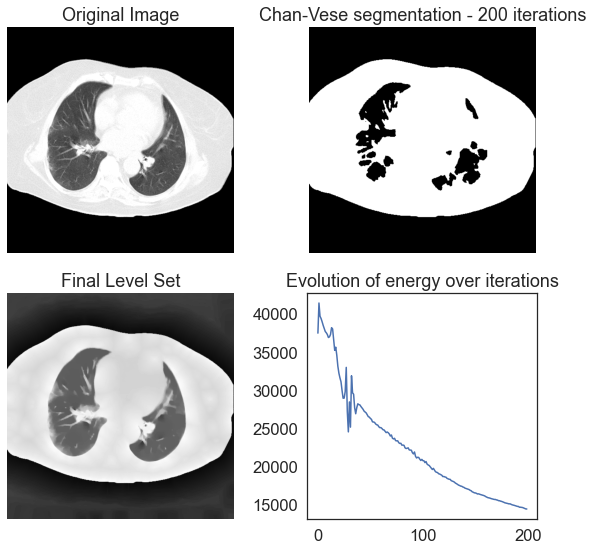

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(img, cmap='gray')
ax[0].set_axis_off()
ax[0].set_title('Original Image')

ax[1].imshow(cv[0], cmap='gray')
ax[1].set_axis_off()
ax[1].set_title('Chan-Vese segmentation - {} iterations'.format(len(cv[2])))

ax[2].imshow(cv[1], cmap='gray')
ax[2].set_axis_off()
ax[2].set_title('Final Level Set')

ax[3].plot(cv[2])
ax[3].set_title('Evolution of energy over iterations')

fig.tight_layout();

### SLIC

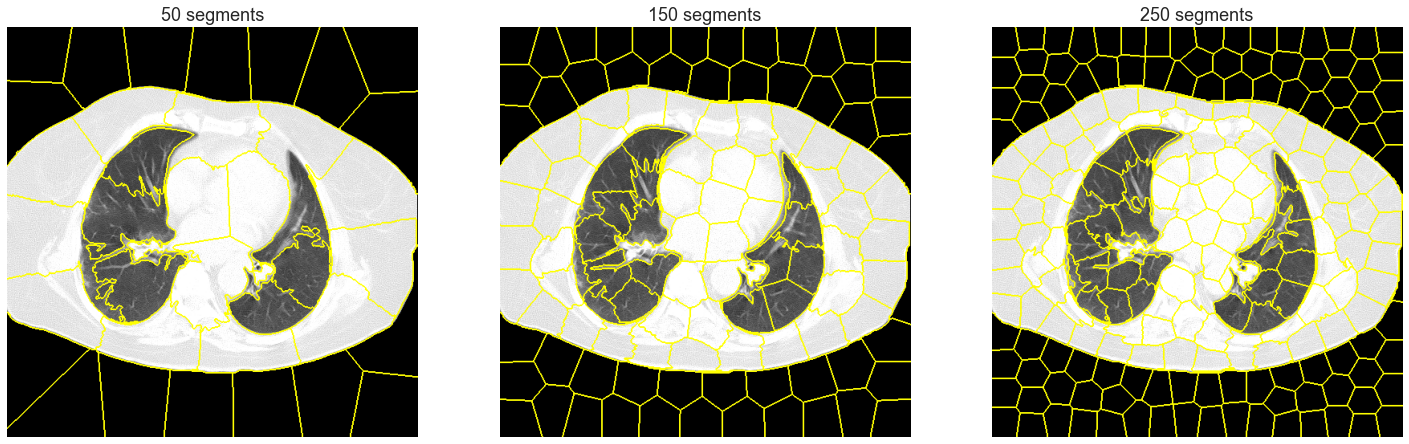

In [12]:
plt.figure(figsize=(25,15))

for i, num_segments in enumerate([50, 150, 250]):
    segments = slic(img, n_segments=num_segments, compactness=0.1, sigma=1, start_label=1, max_iter=50)

    plt.subplot(1,3,i+1)
    plt.imshow(mark_boundaries(img, segments))
    plt.title(str(num_segments) +' segments')
    plt.axis('off');

### Morphological snakes - Morphological ACWE

In [13]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in the given list."""

    def _store(x):
        lst.append(np.copy(x))

    return _store

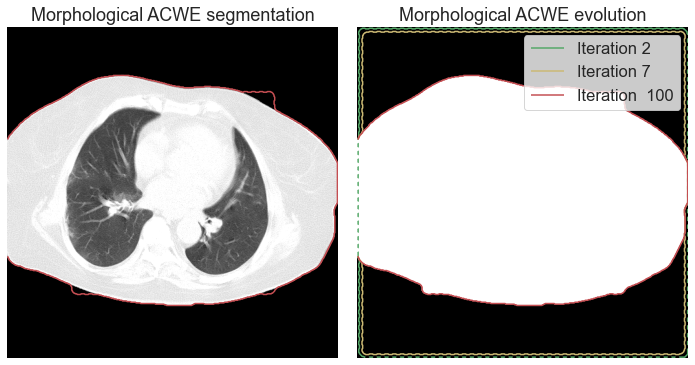

In [83]:
init_ls = checkerboard_level_set(img.shape, 6)
init_ls_circle = disk_level_set(img.shape)

evolution = []
callback = store_evolution_in(evolution)

ls = morphological_chan_vese(img, 100, init_level_set=init_ls, smoothing=5, iter_callback=callback, lambda1=1, lambda2=5)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
ax = axes.flatten()

ax[0].imshow(img, cmap='gray')
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title('Morphological ACWE segmentation')

ax[1].imshow(ls, cmap='gray')
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label('Iteration 2')
contour = ax[1].contour(evolution[7], [0.5], colors='y')
contour.collections[0].set_label('Iteration 7')
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label('Iteration  ' + str(len(evolution)-1))
ax[1].legend(loc='upper right')
ax[1].set_title('Morphological ACWE evolution')

fig.tight_layout();

### Morphological snakes - Morphological GAC

/home/marta/anaconda3/lib/python3.7/site-packages/skimage/segmentation/morphsnakes.py:106: FutureWarning: circle_level_set is deprecated in favor of disk_level_set.circle_level_set will be removed in version 0.19
  res = circle_level_set(image_shape)


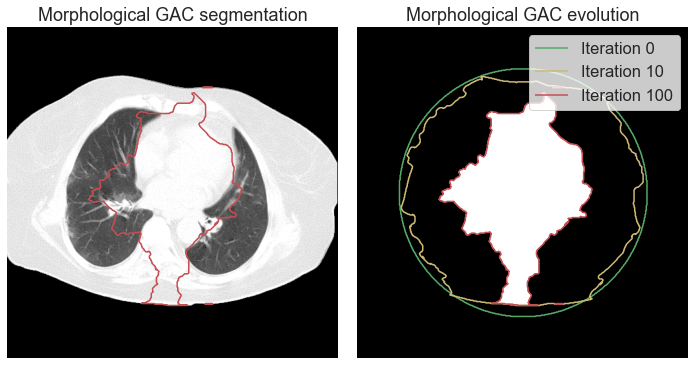

In [84]:
gimage = inverse_gaussian_gradient(img)

init_ls = np.zeros(img.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1

evolution = []
callback = store_evolution_in(evolution)

ls = morphological_geodesic_active_contour(gimage, 100, init_level_set='circle', smoothing=1, balloon=-1, threshold=0.4, iter_callback=callback)


fig, axes = plt.subplots(1, 2, figsize=(10, 10))
ax = axes.flatten()

ax[0].imshow(img, cmap='gray')
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title('Morphological GAC segmentation')

ax[1].imshow(ls, cmap='gray')
ax[1].set_axis_off()
contour = ax[1].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label('Iteration 0')
contour = ax[1].contour(evolution[10], [0.5], colors='y')
contour.collections[0].set_label('Iteration 10')
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label('Iteration ' + str(len(evolution)-1))
ax[1].legend(loc='upper right')
ax[1].set_title('Morphological GAC evolution')

fig.tight_layout();